# VAE and AE

In [42]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import cv2
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM
from pathlib import Path

## 1. Load data, create dataset and dataloader

In [43]:
eye_data = np.load('eye/data.npy') # (1476, 50, 50, 3)
eye_data = eye_data.transpose(0, 3, 1, 2) # (1476, 3, 50, 50)
eye_data = torch.Tensor(eye_data)

eye_label = np.load('eye/label.npy') # (1476, 1)
eye_label = torch.Tensor(eye_label)


In [44]:
print(type(eye_data))

<class 'torch.Tensor'>


In [136]:
BATCH = 18 
EPOCHS = 200
LATENT_DIM = 64 * 7 * 7# 512

In [131]:
class EyeDataset(Dataset):
    def __init__(self, data, label, transform=None):
        print("data shape: ", data.shape)
        print()
        self.data = data
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.label[idx]
        if self.transform:
            data = self.transform(data)
        
        return data, label

In [132]:
eye_dataset = EyeDataset(data=eye_data, label=eye_label)

eye_dataloader = DataLoader(eye_dataset, batch_size=BATCH, shuffle=True)
eye_eval_dataloader = DataLoader(eye_dataset, batch_size=1, shuffle=False)

for batch, label in eye_dataloader:
    print(type(batch))
    print(type(label))
    print(batch.shape)
    print(label.shape)
    # print(batch)
    break

data shape:  torch.Size([1476, 3, 50, 50])

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([18, 3, 50, 50])
torch.Size([18, 1])


## 2. Model construct and train

### 2.1 AE

In [142]:
# Define Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1), # output size is (N, 16, 25, 25)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # output size is (N, 32, 13, 13)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # output size is (N, 64, 7, 7)
            nn.ReLU(),
            
            nn.Flatten(),  # Flatten the output of the convolutional layers
            # nn.Linear(64 * 7 * 7, LATENT_DIM),  # Add a fully connected layer
            # nn.ReLU()
        )
        # self.fc_tolatent = nn.Linear(64 * 7 * 7, LATENT_DIM)  # Add a fully connected layer
        # self.fc_ReLU = nn.ReLU()
        # self.fc_fromlatent = nn.Linear(LATENT_DIM, 64 * 7 * 7)  # Add a fully connected layer
        self.decoder = nn.Sequential(
            # nn.Linear(LATENT_DIM, 64 * 7 * 7),  # FC layer to map hidden vector to initial shape
            # nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),  # Unflatten to 4D tensor
            
            nn.ConvTranspose2d(64, 32, 3, 2, 1), # output size is (N, 32, 13, 13)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1), # output size is (N, 16, 25, 25)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, 2, 1, output_padding=1), # output size is (N, 3, 50, 50)
            nn.Sigmoid()
        )

    def forward(self, x, add_noise=False, noise=0.0):
        encoded = self.encoder(x)
        
        # encoded = self.fc_tolatent(encoded)
        if add_noise:
            encoded = encoded + noise
        # encoded = self.fc_ReLU(encoded)
        # encoded = self.fc_fromlatent(encoded)
        # encoded = self.fc_ReLU(encoded)
        
        decoded = self.decoder(encoded)
        return decoded

# Instantiate the Autoencoder
ae = Autoencoder()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

In [143]:
ae_train_loss_list = []
# AE Training loop
for epoch in range(EPOCHS):
    for batch_data, _ in eye_dataloader:
        optimizer.zero_grad()
        reconstructions = ae(batch_data)
        loss = criterion(reconstructions, batch_data)
        loss.backward()
        optimizer.step()
        
    ae_train_loss_list.append(loss.item())
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")

Epoch [1/200], Loss: 0.0108
Epoch [10/200], Loss: 0.0025
Epoch [20/200], Loss: 0.0023
Epoch [30/200], Loss: 0.0016
Epoch [40/200], Loss: 0.0015
Epoch [50/200], Loss: 0.0015
Epoch [60/200], Loss: 0.0013
Epoch [70/200], Loss: 0.0011
Epoch [80/200], Loss: 0.0008
Epoch [90/200], Loss: 0.0009
Epoch [100/200], Loss: 0.0009
Epoch [110/200], Loss: 0.0008
Epoch [120/200], Loss: 0.0006
Epoch [130/200], Loss: 0.0007
Epoch [140/200], Loss: 0.0007
Epoch [150/200], Loss: 0.0006
Epoch [160/200], Loss: 0.0005
Epoch [170/200], Loss: 0.0006
Epoch [180/200], Loss: 0.0005
Epoch [190/200], Loss: 0.0004
Epoch [200/200], Loss: 0.0004


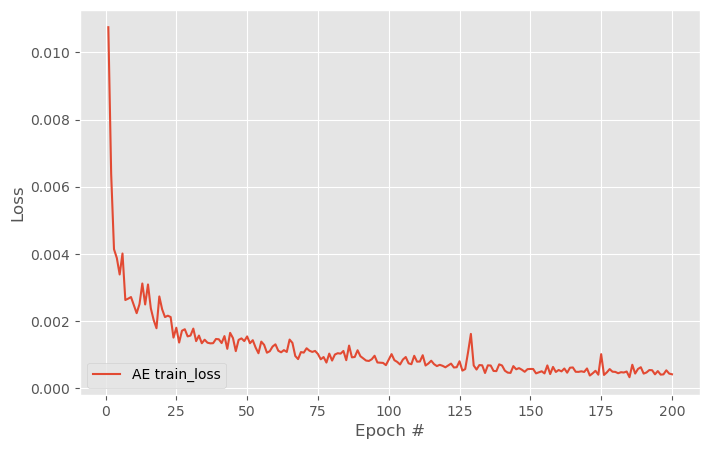

In [145]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 5))
fig.add_subplot(2,2,(1,4))
plt.style.use("ggplot")

plt.plot(range(1, EPOCHS+1), ae_train_loss_list, label="AE train_loss")

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

### 2.2 VAE

In [135]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1), # output size is (N, 16, 25, 25)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # output size is (N, 32, 13, 13)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # output size is (N, 64, 7, 7)
            nn.ReLU(),
            
            nn.Flatten(),  # Flatten the output of the convolutional layers
            # nn.Linear(64 * 7 * 7, 256),  # Add a fully connected layer
            # nn.ReLU()
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, LATENT_DIM)
        self.fc_logvar = nn.Linear(64 * 7 * 7, LATENT_DIM)
        
        self.decoder = nn.Sequential(
            # nn.Linear(LATENT_DIM, 64 * 7 * 7),  # FC layer to map hidden vector to initial shape
            # nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),  # Unflatten to 4D tensor
            
            nn.ConvTranspose2d(64, 32, 3, 2, 1), # output size is (N, 32, 13, 13)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1), # output size is (N, 16, 25, 25)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, 2, 1, output_padding=1), # output size is (N, 3, 50, 50)
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x, add_noise=False, noise=0.0):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        if add_noise:
            z = z +noise
        decoded = self.decoder(z)
        return decoded, mu, logvar

# Instantiate the VAE
vae = VariationalAutoEncoder()

# Define loss function and optimizer
def vae_loss(recons, originals, mu, logvar):
    recons_loss = F.mse_loss(recons, originals, reduction='sum')
    kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    # kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recons_loss, kl_loss, recons_loss + kl_loss

optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

In [137]:
# VAE Training loop
vae_train_loss_list = []
recons_loss_list = []
kl_loss_list = []
for epoch in range(EPOCHS):
    for batch_data, _ in eye_dataloader:
        optimizer.zero_grad()
        reconstructions, mu, logvar = vae(batch_data)
        recons_loss, kl_loss, loss = vae_loss(reconstructions, batch_data, mu, logvar)
        loss.backward()
        optimizer.step()
    vae_train_loss_list.append(loss.item())
    recons_loss_list.append(recons_loss.item())
    kl_loss_list.append(kl_loss.item())
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Recons: {recons_loss.item():.4f}, KL: {kl_loss.item():.4f}")

Epoch [1/200], Loss: 2577.3499, Recons: 2284.2683, KL: 293.0815
Epoch [10/200], Loss: 1171.6993, Recons: 794.0858, KL: 377.6135
Epoch [20/200], Loss: 827.6075, Recons: 542.2861, KL: 285.3214
Epoch [30/200], Loss: 828.6851, Recons: 554.4773, KL: 274.2077
Epoch [40/200], Loss: 791.1243, Recons: 512.9638, KL: 278.1605
Epoch [50/200], Loss: 767.1478, Recons: 491.2041, KL: 275.9437
Epoch [60/200], Loss: 713.0349, Recons: 432.1801, KL: 280.8547
Epoch [70/200], Loss: 758.8096, Recons: 461.9330, KL: 296.8765
Epoch [80/200], Loss: 667.9404, Recons: 390.5171, KL: 277.4233
Epoch [90/200], Loss: 766.7100, Recons: 466.3776, KL: 300.3324
Epoch [100/200], Loss: 658.1112, Recons: 381.5402, KL: 276.5711
Epoch [110/200], Loss: 715.1469, Recons: 423.8000, KL: 291.3468
Epoch [120/200], Loss: 639.2485, Recons: 368.2274, KL: 271.0211
Epoch [130/200], Loss: 621.8594, Recons: 346.4796, KL: 275.3799
Epoch [140/200], Loss: 596.6805, Recons: 331.4522, KL: 265.2283
Epoch [150/200], Loss: 686.9626, Recons: 402.655

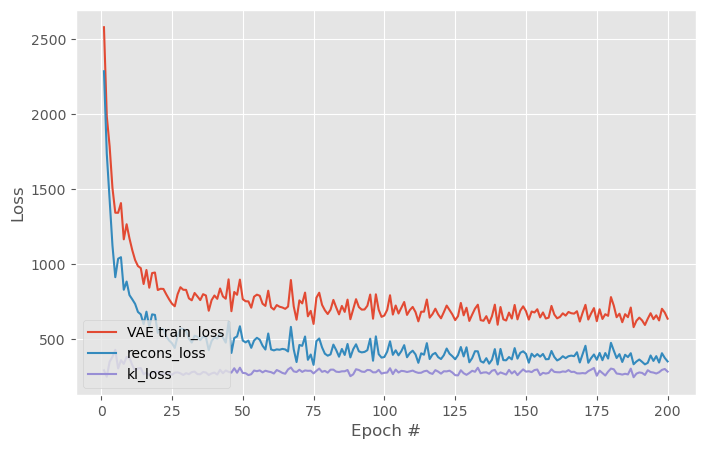

In [138]:
fig = plt.figure(figsize=(8, 5))
fig.add_subplot(2,2,(1,4))
plt.style.use("ggplot")

plt.plot(range(1, EPOCHS+1), vae_train_loss_list, label="VAE train_loss")
plt.plot(range(1, EPOCHS+1), recons_loss_list, label="recons_loss")
plt.plot(range(1, EPOCHS+1), kl_loss_list, label="kl_loss")

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

plt.show()

## 4. Save model, evaluate and show picture

In [146]:
Path("vae_result/").mkdir(parents=True, exist_ok=True)
Path("ae_result/").mkdir(parents=True, exist_ok=True)

In [147]:
vae_file_path = 'VAE.pt'
torch.save(vae, vae_file_path)
ae_file_path = 'AE.pt'
torch.save(ae, ae_file_path)

ae PSNR:34.111779961067576, SSIM:0.9627587795257568
vae PSNR:25.869730189767193, SSIM:0.7805314064025879


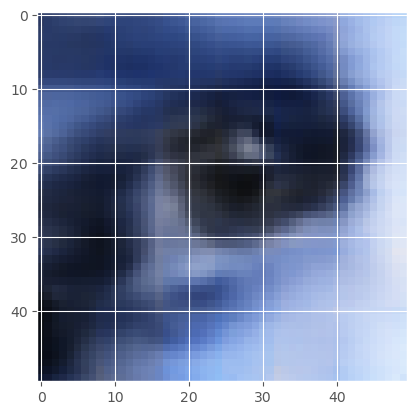

In [148]:
ae_recons_result_list = []
ae_PSNR_list = []
ae_SSIM_list = []
vae_recons_result_list = []
vae_PSNR_list = []
vae_SSIM_list = []


ae_model = torch.load(ae_file_path)
vae_model = torch.load(vae_file_path)
ae_model.eval()
vae_model.eval() 

# for batch_data, _ in eye_eval_dataloader:
for i, (batch_data, _) in enumerate(eye_eval_dataloader):
    with torch.no_grad():
        optimizer.zero_grad()
        ae_reconstructions = ae(batch_data)
        vae_reconstructions, _, _ = vae(batch_data)
        
        vae_recon_img = torch.squeeze(vae_reconstructions).permute(1, 2, 0).numpy()
        ae_recon_img = torch.squeeze(ae_reconstructions).permute(1, 2, 0).numpy()
        batch_img = torch.squeeze(batch_data).permute(1, 2, 0).numpy()
        if i+1 in [91, 92, 93, 94, 95, 481, 482, 483, 484, 485, 936, 937, 938, 939, 940, 1446, 1447, 1448, 1449, 1450]:
            plt.imshow(ae_recon_img)
            plt.savefig(f'ae_result/{i+1}.png')
            plt.imshow(vae_recon_img)
            plt.savefig(f'vae_result/{i+1}.png')


        ae_psnr_result = PSNR(ae_recon_img, batch_img)
        ae_ssim_result = SSIM(ae_recon_img, batch_img, multichannel=True, data_range=ae_recon_img.max() - ae_recon_img.min(),channel_axis=2)
        ae_PSNR_list.append(ae_psnr_result)   
        ae_SSIM_list.append(ae_ssim_result)
        
        vae_psnr_result = PSNR(vae_recon_img, batch_img)
        vae_ssim_result = SSIM(vae_recon_img, batch_img, multichannel=True, data_range=vae_recon_img.max() - vae_recon_img.min(),channel_axis=2)
        vae_PSNR_list.append(vae_psnr_result)   
        vae_SSIM_list.append(vae_ssim_result)

print(f'ae PSNR:{np.mean(ae_PSNR_list)}, SSIM:{np.mean(ae_SSIM_list)}')
print(f'vae PSNR:{np.mean(vae_PSNR_list)}, SSIM:{np.mean(vae_SSIM_list)}')

## 5. Evaluate with Gaussian Noise

In [175]:
Path("noise_ae_result/").mkdir(parents=True, exist_ok=True)
Path("noise_vae_result/").mkdir(parents=True, exist_ok=True)

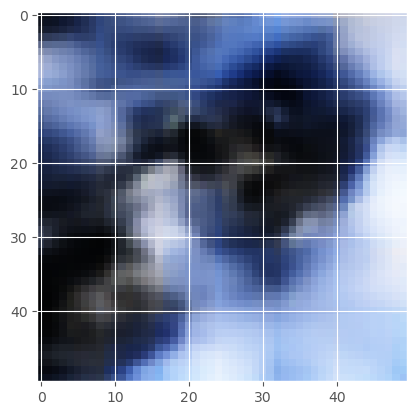

In [176]:
ae_model = torch.load(ae_file_path)
vae_model = torch.load(vae_file_path)
ae_model.eval()
vae_model.eval() 

# for batch_data, _ in eye_eval_dataloader:
for i, (batch_data, _) in enumerate(eye_eval_dataloader):
    with torch.no_grad():
        optimizer.zero_grad()
        Gaussian_noise = torch.randn(LATENT_DIM)
        ae_reconstructions = ae(batch_data, add_noise=True, noise=Gaussian_noise)
        vae_reconstructions, _, _ = vae(batch_data, add_noise=True, noise=Gaussian_noise)
        
        vae_recon_img = torch.squeeze(vae_reconstructions).permute(1, 2, 0).numpy()
        ae_recon_img = torch.squeeze(ae_reconstructions).permute(1, 2, 0).numpy()
        batch_img = torch.squeeze(batch_data).permute(1, 2, 0).numpy()
        if i+1 in [91, 92, 93, 94, 95, 481, 482, 483, 484, 485, 936, 937, 938, 939, 940, 1446, 1447, 1448, 1449, 1450]:
            plt.imshow(ae_recon_img)
            plt.savefig(f'noise_ae_result/{i+1}.png')
            plt.imshow(vae_recon_img)
            plt.savefig(f'noise_vae_result/{i+1}.png')


## 6. Skip connection Version

In [165]:
class SkipConnectionVAE(nn.Module):
    def __init__(self):
        super(SkipConnectionVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1), # output size is (N, 16, 25, 25)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # output size is (N, 32, 13, 13)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # output size is (N, 64, 7, 7)
            nn.ReLU(),
            
            nn.Flatten(),  # Flatten the output of the convolutional layers
            # nn.Linear(64 * 7 * 7, 256),  # Add a fully connected layer
            # nn.ReLU()
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, LATENT_DIM)
        self.fc_logvar = nn.Linear(64 * 7 * 7, LATENT_DIM)
        
        self.decoder = nn.Sequential(
            # nn.Linear(LATENT_DIM, 64 * 7 * 7),  # FC layer to map hidden vector to initial shape
            # nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),  # Unflatten to 4D tensor (N, 64, 7, 7)
            
            nn.ConvTranspose2d(64, 32, 3, 2, 1), # output size is (N, 32, 13, 13)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1), # output size is (N, 16, 25, 25)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, 2, 1, output_padding=1), # output size is (N, 3, 50, 50)
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        encode_list = []
        for idx, layer in enumerate(self.encoder):
            x = layer(x)
            if idx in [0, 2, 4]:
                encode_list.append(x)
    
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        x = self.reparameterize(mu, logvar)
            
        for idx, layer in enumerate(self.decoder):
            x = layer(x)
            if idx in [0, 1, 3]:
                x = x + encode_list.pop() # Add with skip connection
        
        return x, mu, logvar
    

# Instantiate the VAE
skvae = SkipConnectionVAE()

# Define loss function and optimizer
def skvae_loss(recons, originals, mu, logvar):
    recons_loss = F.mse_loss(recons, originals, reduction='sum')
    kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    # kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recons_loss, kl_loss, recons_loss + kl_loss

sk_optimizer = torch.optim.Adam(skvae.parameters(), lr=0.001)

In [166]:
# Skip Connection VAE Training loop
skvae_train_loss_list = []
sk_recons_loss_list = []
sk_kl_loss_list = []
for epoch in range(EPOCHS):
    for batch_data, _ in eye_dataloader:
        sk_optimizer.zero_grad()
        reconstructions, mu, logvar = skvae(batch_data)
        sk_recons_loss, sk_kl_loss, sk_loss = skvae_loss(reconstructions, batch_data, mu, logvar)
        sk_loss.backward()
        sk_optimizer.step()
    
    skvae_train_loss_list.append(sk_loss.item())
    sk_recons_loss_list.append(sk_recons_loss.item())
    sk_kl_loss_list.append(sk_kl_loss.item())
    
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"skvae Epoch [{epoch+1}/{EPOCHS}], Loss: {sk_loss.item():.4f}, Recons: {sk_recons_loss.item():.4f}, KL: {sk_kl_loss.item():.4f}")

skvae Epoch [1/200], Loss: 1366.9995, Recons: 1277.3208, KL: 89.6787
skvae Epoch [10/200], Loss: 241.1398, Recons: 237.4709, KL: 3.6689
skvae Epoch [20/200], Loss: 185.1557, Recons: 183.7025, KL: 1.4532
skvae Epoch [30/200], Loss: 127.5054, Recons: 126.9522, KL: 0.5532
skvae Epoch [40/200], Loss: 86.8623, Recons: 86.4657, KL: 0.3966
skvae Epoch [50/200], Loss: 57.2263, Recons: 56.9321, KL: 0.2942
skvae Epoch [60/200], Loss: 64.5850, Recons: 64.1531, KL: 0.4319
skvae Epoch [70/200], Loss: 67.0078, Recons: 66.6712, KL: 0.3366
skvae Epoch [80/200], Loss: 51.4166, Recons: 51.2900, KL: 0.1266
skvae Epoch [90/200], Loss: 32.9826, Recons: 32.8602, KL: 0.1224
skvae Epoch [100/200], Loss: 31.6056, Recons: 31.5185, KL: 0.0871
skvae Epoch [110/200], Loss: 36.2530, Recons: 35.9473, KL: 0.3057
skvae Epoch [120/200], Loss: 27.8987, Recons: 27.7759, KL: 0.1228
skvae Epoch [130/200], Loss: 24.4611, Recons: 24.3321, KL: 0.1290
skvae Epoch [140/200], Loss: 22.1450, Recons: 22.0235, KL: 0.1214
skvae Epoc

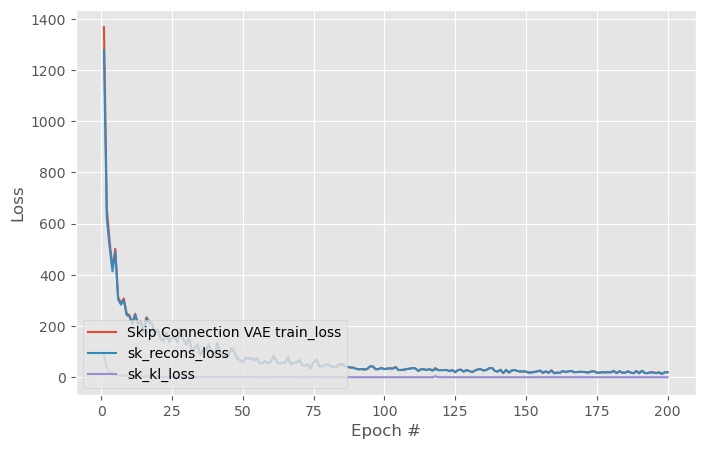

In [167]:
fig = plt.figure(figsize=(8, 5))
fig.add_subplot(2,2,(1,4))
plt.style.use("ggplot")

plt.plot(range(1, EPOCHS+1), skvae_train_loss_list, label="Skip Connection VAE train_loss")
plt.plot(range(1, EPOCHS+1), sk_recons_loss_list, label="sk_recons_loss")
plt.plot(range(1, EPOCHS+1), sk_kl_loss_list, label="sk_kl_loss")

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

plt.show()

## 7. Deeper Version

In [168]:
class DeeperVAE(nn.Module):
    def __init__(self):
        super(DeeperVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1), # output size is (N, 16, 25, 25)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # output size is (N, 32, 13, 13)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # output size is (N, 64, 7, 7)
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), # output size is (N, 128, 4, 4)
            nn.ReLU(),
            nn.Flatten(),  # Flatten the output of the convolutional layers
            # nn.Linear(64 * 7 * 7, 256),  # Add a fully connected layer
            # nn.ReLU()
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, 128 * 4 * 4)
        self.fc_logvar = nn.Linear(128 * 4 * 4, 128 * 4 * 4)
        
        self.decoder = nn.Sequential(
            # nn.Linear(LATENT_DIM, 64 * 7 * 7),  # FC layer to map hidden vector to initial shape
            # nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),  # Unflatten to 4D tensor (N, 128, 4, 4)
            nn.ConvTranspose2d(128, 64, 3, 2, 1), # output size is (N, 64, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2, 1), # output size is (N, 32, 13, 13)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1), # output size is (N, 16, 25, 25)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, 2, 1, output_padding=1), # output size is (N, 3, 50, 50)
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x, add_noise=False, noise=0.0):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        if add_noise:
            z = z +noise
        decoded = self.decoder(z)
        return decoded, mu, logvar

# Instantiate the VAE
dpvae = DeeperVAE()

# Define loss function and optimizer
def dpvae_loss(recons, originals, mu, logvar):
    recons_loss = F.mse_loss(recons, originals, reduction='sum')
    kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    # kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recons_loss, kl_loss, recons_loss + kl_loss

dp_optimizer = torch.optim.Adam(dpvae.parameters(), lr=0.001)

In [169]:
# Deeper VAE Training loop
dpvae_train_loss_list = []
dp_recons_loss_list = []
dp_kl_loss_list = []
for epoch in range(EPOCHS):
    for batch_data, _ in eye_dataloader:
        dp_optimizer.zero_grad()
        reconstructions, mu, logvar = dpvae(batch_data)
        dp_recons_loss, dp_kl_loss, dp_loss = dpvae_loss(reconstructions, batch_data, mu, logvar)
        dp_loss.backward()
        dp_optimizer.step()
    dpvae_train_loss_list.append(dp_loss.item())
    dp_recons_loss_list.append(dp_recons_loss.item())
    dp_kl_loss_list.append(dp_kl_loss.item())
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {dp_loss.item():.4f}, Recons: {dp_recons_loss.item():.4f}, KL: {dp_kl_loss.item():.4f}")

Epoch [1/200], Loss: 3432.6904, Recons: 3271.7822, KL: 160.9081
Epoch [10/200], Loss: 1208.9825, Recons: 938.1160, KL: 270.8665
Epoch [20/200], Loss: 909.5282, Recons: 724.7648, KL: 184.7634
Epoch [30/200], Loss: 786.6982, Recons: 594.9854, KL: 191.7128
Epoch [40/200], Loss: 674.2970, Recons: 487.6544, KL: 186.6426
Epoch [50/200], Loss: 735.7363, Recons: 543.9802, KL: 191.7561
Epoch [60/200], Loss: 719.3856, Recons: 529.9800, KL: 189.4055
Epoch [70/200], Loss: 782.8215, Recons: 568.7036, KL: 214.1180
Epoch [80/200], Loss: 689.2108, Recons: 491.8573, KL: 197.3535
Epoch [90/200], Loss: 670.0011, Recons: 468.9653, KL: 201.0358
Epoch [100/200], Loss: 696.0652, Recons: 493.9009, KL: 202.1643
Epoch [110/200], Loss: 655.5906, Recons: 453.6923, KL: 201.8983
Epoch [120/200], Loss: 653.3218, Recons: 452.5256, KL: 200.7961
Epoch [130/200], Loss: 646.3677, Recons: 435.2897, KL: 211.0780
Epoch [140/200], Loss: 572.4243, Recons: 370.4816, KL: 201.9426
Epoch [150/200], Loss: 624.1207, Recons: 418.394

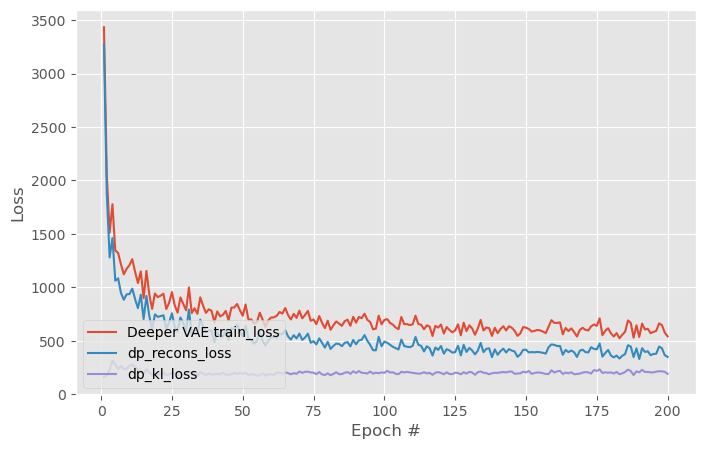

In [170]:
fig = plt.figure(figsize=(8, 5))
fig.add_subplot(2,2,(1,4))
plt.style.use("ggplot")

plt.plot(range(1, EPOCHS+1), dpvae_train_loss_list, label="Deeper VAE train_loss")
plt.plot(range(1, EPOCHS+1), dp_recons_loss_list, label="dp_recons_loss")
plt.plot(range(1, EPOCHS+1), dp_kl_loss_list, label="dp_kl_loss")

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

plt.show()

## 8. Save Deeper and Skip connection version model

In [173]:
Path("skvae_result/").mkdir(parents=True, exist_ok=True)
Path("dpvae_result/").mkdir(parents=True, exist_ok=True)
skvae_file_path = 'SK.pt'
dpvae_file_path = 'DP.pt'
torch.save(skvae, skvae_file_path)
torch.save(dpvae, dpvae_file_path)

skvae PSNR:39.42874809623816, SSIM:0.9879997372627258
dpvae PSNR:25.712762055780342, SSIM:0.7690593600273132


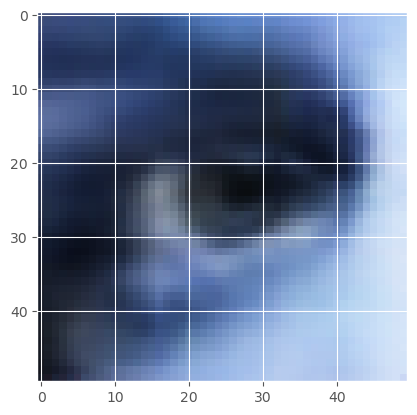

In [174]:
skvae_recons_result_list = []
skvae_PSNR_list = []
skvae_SSIM_list = []
dpvae_recons_result_list = []
dpvae_PSNR_list = []
dpvae_SSIM_list = []

skvae_model = torch.load(skvae_file_path)
dpvae_model = torch.load(dpvae_file_path)
skvae_model.eval()
dpvae_model.eval() 

# for batch_data, _ in eye_eval_dataloader:
for i, (batch_data, _) in enumerate(eye_eval_dataloader):
    with torch.no_grad():
        sk_optimizer.zero_grad()
        dp_optimizer.zero_grad()
        skvae_reconstructions, _, _ = skvae(batch_data)
        dpvae_reconstructions, _, _ = dpvae(batch_data)
        
        skvae_recon_img = torch.squeeze(skvae_reconstructions).permute(1, 2, 0).numpy()
        dpvae_recon_img = torch.squeeze(dpvae_reconstructions).permute(1, 2, 0).numpy()
        batch_img = torch.squeeze(batch_data).permute(1, 2, 0).numpy()
        if i+1 in [91, 92, 93, 94, 95, 481, 482, 483, 484, 485, 936, 937, 938, 939, 940, 1446, 1447, 1448, 1449, 1450]:
            plt.imshow(skvae_recon_img)
            plt.savefig(f'skvae_result/{i+1}.png')
            plt.imshow(dpvae_recon_img)
            plt.savefig(f'dpvae_result/{i+1}.png')


        skvae_psnr_result = PSNR(skvae_recon_img, batch_img)
        skvae_ssim_result = SSIM(skvae_recon_img, batch_img, multichannel=True, data_range=skvae_recon_img.max() - skvae_recon_img.min(),channel_axis=2)
        skvae_PSNR_list.append(skvae_psnr_result)   
        skvae_SSIM_list.append(skvae_ssim_result)
        
        dpvae_psnr_result = PSNR(dpvae_recon_img, batch_img)
        dpvae_ssim_result = SSIM(dpvae_recon_img, batch_img, multichannel=True, data_range=dpvae_recon_img.max() - dpvae_recon_img.min(),channel_axis=2)
        dpvae_PSNR_list.append(dpvae_psnr_result)   
        dpvae_SSIM_list.append(dpvae_ssim_result)

print(f'skvae PSNR:{np.mean(skvae_PSNR_list)}, SSIM:{np.mean(skvae_SSIM_list)}')
print(f'dpvae PSNR:{np.mean(dpvae_PSNR_list)}, SSIM:{np.mean(dpvae_SSIM_list)}')